In [1]:
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from NegativeClassOptimization import config, ml, preprocessing, datasets, utils, visualisations
import torch

In [2]:
def evaluate_model(
    model: torch.nn.Module,
    test_dataset: pd.DataFrame,
):
    """
    Evaluates a model on a test dataset.
    """
    with torch.no_grad():
        X = np.stack(test_dataset["X"])  # type: ignore
        X = torch.from_numpy(X).float()
        y_pred = model(X).round().detach().numpy().reshape(-1)
        y_true = test_dataset["binds_a_pos_ag"].values
        metrics = ml.compute_binary_metrics(y_pred, y_true)
    return metrics

In [3]:
pos_tes_size = 5000
neg_test_size = np.array([2, 5, 10, 15])*pos_tes_size
extra_neg_size = neg_test_size - 5000
extra_neg_size_dict = dict(zip(['1:2', '1:5', '1:10', '1:15'], extra_neg_size))

In [4]:
#load trained model
task_types = (
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

In [5]:
def create_task(task_type, ag):
    task = datasets.ClassificationTask(
        task_type=task_type,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )
    return task


In [6]:
#source of extra vs9 negatives 
df_rest_binders = []
for ag in config.ANTIGENS:
    df_ag_full = utils.load_testrest_from_miniabsolut(ag)
    df_ag_bind_rest = df_ag_full.query(f'binder_type == "{ag}_high" and origin == "rest"')
    df_ag_bind_rest = df_ag_bind_rest[['ID_slide_Variant', 'Slide', 'Energy', 'binder_type', 'origin']]
    df_rest_binders.append(df_ag_bind_rest)
df_rest_binders = pd.concat(df_rest_binders)

In [7]:
task_suffixes = {'ONE_VS_NINE':'_high', 'HIGH_VS_LOOSER': '_looserX', 'HIGH_VS_95LOW': '_95low'}
def get_extra_neg_source(task_type, ag):
    task_name = task_type.name
    df_ag_full = utils.load_testrest_from_miniabsolut(ag)

    if task_name == 'ONE_VS_NINE':
        df_extra_neg = df_rest_binders.query(f'binder_type != "{ag}_high"')
    else:
        df_extra_neg = df_ag_full.query(f'binder_type == "{ag}{task_suffixes[task_name]}" and origin == "rest"')
    
    df_extra_neg = df_extra_neg.sample(frac=1, random_state=42).copy()
    df_extra_neg['binds_a_pos_ag'] = 0
    return df_extra_neg[['Slide', 'binds_a_pos_ag']]

def create_unbalanced_test(df_extra_neg, neg_size):
    df_shuffled_rows = df_extra_neg.sample(frac=1, random_state=42).copy()
    sampled_extra_neg = df_shuffled_rows.sample(neg_size, random_state=42).copy()
    return sampled_extra_neg

In [26]:
neg_ratio_res = []  # [ag, id_task, test_task, neg_ratio, 'acc', 'recall', 'precision', 'f1']
for ag in config.ANTIGENS:
    for train_task_type in task_types:
        train_task = create_task(train_task_type, ag)
        model = loader.load(train_task, load_model=True, load_test_dataset=False, load_train_dataset=False).model
        for test_task_type in task_types:
            test_task = create_task(test_task_type, ag)
            balanced_test = loader.load(test_task, load_model=False, load_test_dataset=True, load_train_dataset=False).test_dataset
            balanced_test['X'] = balanced_test['Slide'].apply(lambda x: preprocessing.onehot_encode(x))
            balanced_test = balanced_test[['Slide', 'binds_a_pos_ag', 'X']]
            metrics = evaluate_model(model, balanced_test)
            neg_ratio_res.append([ag, train_task_type.name, test_task_type.name, '1:1', *metrics.values()])

            # now we create data with extra negatives and test
            df_extra_neg = get_extra_neg_source(test_task_type, ag)
            for neg_ratio, extra_neg_amount in extra_neg_size_dict.items():
                try:
                    extra_neg_df = create_unbalanced_test(df_extra_neg, extra_neg_amount)
                    extra_neg_df['X'] = extra_neg_df['Slide'].apply(lambda x: preprocessing.onehot_encode(x))

                    df_test = pd.concat([balanced_test, extra_neg_df])
                    metrics = evaluate_model(model, df_test)
                    neg_ratio_res.append([ag, train_task_type.name, test_task_type.name, neg_ratio, *metrics.values()])
                except:
                    print(f'Not enough negatives for {ag} {test_task_type.name}, {neg_ratio} failed')


Not enough negatives for 3VRL ONE_VS_NINE, 1:15 failed
Not enough negatives for 3VRL ONE_VS_NINE, 1:15 failed
Not enough negatives for 3VRL ONE_VS_NINE, 1:15 failed
Not enough negatives for 1NSN ONE_VS_NINE, 1:15 failed
Not enough negatives for 1NSN ONE_VS_NINE, 1:15 failed
Not enough negatives for 1NSN ONE_VS_NINE, 1:15 failed
Not enough negatives for 3RAJ ONE_VS_NINE, 1:15 failed
Not enough negatives for 3RAJ ONE_VS_NINE, 1:15 failed
Not enough negatives for 3RAJ ONE_VS_NINE, 1:15 failed
Not enough negatives for 5E94 ONE_VS_NINE, 1:15 failed
Not enough negatives for 5E94 ONE_VS_NINE, 1:15 failed
Not enough negatives for 5E94 ONE_VS_NINE, 1:15 failed
Not enough negatives for 1H0D ONE_VS_NINE, 1:15 failed
Not enough negatives for 1H0D ONE_VS_NINE, 1:15 failed
Not enough negatives for 1H0D ONE_VS_NINE, 1:15 failed
Not enough negatives for 1WEJ ONE_VS_NINE, 1:15 failed
Not enough negatives for 1WEJ ONE_VS_NINE, 1:15 failed
Not enough negatives for 1WEJ ONE_VS_NINE, 1:15 failed
Not enough

In [27]:
df_neg_ratios = pd.DataFrame(neg_ratio_res, columns=['ag', 'train_task', 'test_task', 'neg_ratio', 'acc', 'recall', 'precision', 'f1'])
df_neg_ratios.to_csv('neg_ratio_results.csv', index=False)

In [2]:
df_neg_ratios = pd.read_csv('neg_ratio_results.csv')

In [30]:
df_neg_ratios.head()

,ag,train_task,test_task,neg_ratio,acc,recall,precision,f1
0,3VRL,ONE_VS_NINE,ONE_VS_NINE,1:1,0.972986,0.975,0.971116,0.973054
1,3VRL,ONE_VS_NINE,ONE_VS_NINE,1:2,0.975592,0.975,0.952893,0.963820
2,3VRL,ONE_VS_NINE,ONE_VS_NINE,1:5,0.977996,0.975,0.901109,0.936599
3,3VRL,ONE_VS_NINE,ONE_VS_NINE,1:10,0.978253,0.975,0.819879,0.890736
4,3VRL,ONE_VS_NINE,HIGH_VS_95LOW,1:1,0.987000,0.975,0.998975,0.986842


In [3]:
tasks_colors = {
        'HIGH_VS_LOOSER':'#FFC300',
        'HIGH_VS_95LOW':'#00A6ED',
        'ONE_VS_NINE' : '#FF5733',
    }
task_to_clean_name = {
    'HIGH_VS_LOOSER': 'vs Weak',
    'ONE_VS_NINE': 'vs 9' ,
    'HIGH_VS_95LOW': 'vs Non-binder'
}

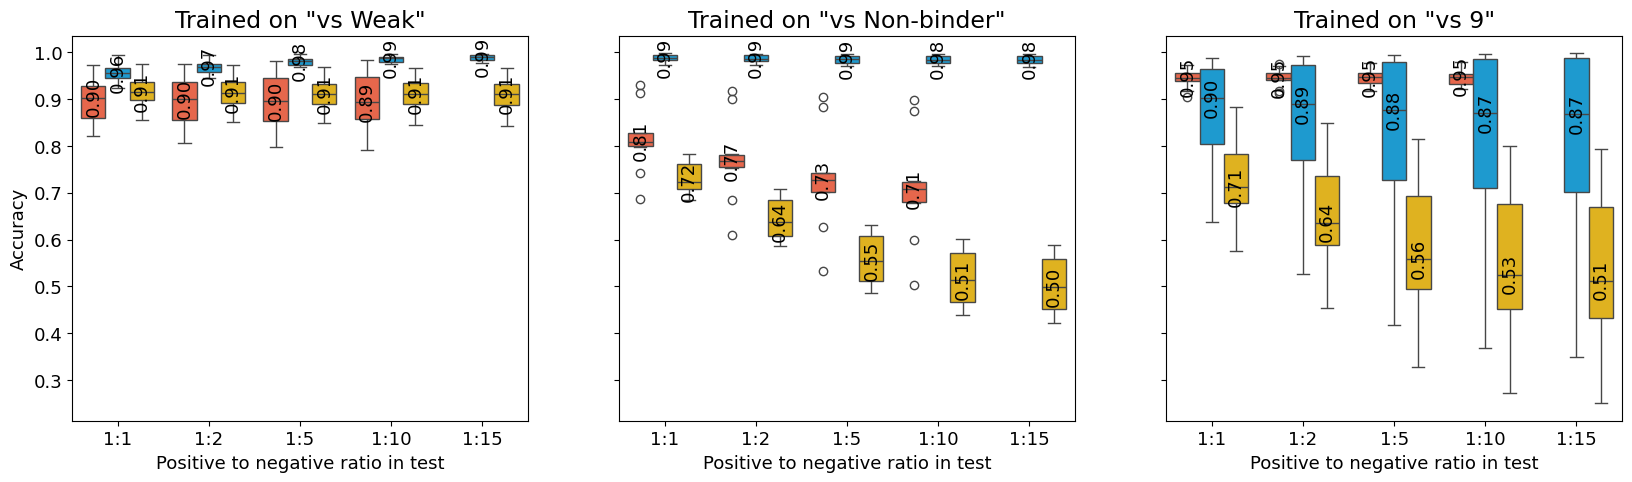

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for i, task in enumerate(tasks_colors.keys()):
    df_focus = df_neg_ratios.query(f'train_task == "{task}"')
    sns.boxplot(data=df_focus, x='neg_ratio', y='acc', hue='test_task', palette=tasks_colors, ax=ax[i], legend=False)
    ax[i].set_title(f'Trained on {task}', fontsize=17)
    task_clean = task_to_clean_name[task]
    ax[i].set_title(f'Trained on "{task_clean}"', fontsize=17)
    ax[i].set_ylabel('Accuracy', fontsize=13)
    ax[i].set_xlabel('Positive to negative ratio in test', fontsize=13)
    #increase text of y and x axis 
    ax[i].tick_params(axis='both', which='major', labelsize=13)

    visualisations.add_median_labels(ax[i],  fontsize=13)
fig.savefig('./figures/negative_ratio_res.svg')

